In [3]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain.chains import RetrievalQA
from dotenv import load_dotenv
import os 
import pandas as pd
from collections import Counter
#환경 변수 로드
load_dotenv()

True

In [4]:
#임베딩 모델 및 언어 모델 정의
embedding_model = OpenAIEmbeddings()
llm = ChatOpenAI(model="gpt-3.5-turbo")

In [5]:
# 문서 정의 예시
df = pd.DataFrame({
    "time": [
        "2025년 6월 25일 오전 8시 15분",
        "2025년 6월 25일 오전 9시 00분",
        "2025년 6월 25일 오후 3시 30분",
        "2025년 6월 25일 오후 6시 18분"
    ],
    "utterance": [
        "짜증나 진짜", "너무 외로워", "와 재밌다", "하 너무 힘들어"
    ],
    "emotion": ["분노", "슬픔", "기쁨", "중립"]
})

# 📌 3. 요약 함수 정의
def summarize_emotions(df):
    emotion_counts = Counter(df["emotion"])
    summary = f"총 {len(df)}개의 발화 중 "
    summary += ", ".join([f"{emo} {cnt}건" for emo, cnt in emotion_counts.items()]) + "이 감지되었습니다.\n"
    
    peak_times = df.groupby("emotion")["time"].apply(list).to_dict()
    for emo, times in peak_times.items():
        summary += f"- '{emo}' 감정은 주로 {', '.join(times[:2])}에 탐지되었습니다.\n"
    
    return summary.strip()

# 📌 4. LangChain 문서화
summary_text = summarize_emotions(df)
docs = [Document(page_content=summary_text)]

# 📌 5. 벡터스토어 생성
vectorstore = FAISS.from_documents(docs, embedding_model)

# 📌 6. QA 체인 구성 및 질의
qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=vectorstore.as_retriever())

query = "오늘 감정은 어땠어?"
response = qa_chain.run(query)
print(response)

C:\Users\asia\.conda\envs\py312tf9\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


오늘 감정은 알 수 없습니다.


In [7]:
# 감정 csv >> 자동 요약 >>> rag 응답
df = pd.read_csv("emotion_log_2025-06-25.csv")  # 파일 경로 수정 가능
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = df["timestamp"].dt.date
df["hour"] = df["timestamp"].dt.strftime("%Y-%m-%d %H시")

# 2. 날짜별로 요약 생성
docs = []
for date, group in df.groupby("date"):
    emotion_counts = Counter(group["emotion"])
    summary = f"{date}에는 총 {len(group)}건의 발화 중 " + \
              ", ".join([f"{emo} {cnt}건" for emo, cnt in emotion_counts.items()]) + \
              "이 감지되었습니다."
    docs.append(Document(page_content=summary))

for hour, group in df.groupby("hour"):
    emotion_counts = Counter(group["emotion"])
    summary = f"{hour}에는 총 {len(group)}건의 감정이 탐지됨. " + \
              ", ".join([f"{emo} {cnt}건" for emo, cnt in emotion_counts.items()]) + \
              " 이 감지되었습니다."
    docs.append(Document(page_content=summary))

# 3. 벡터 저장소 생성
embedding_model = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(docs, embedding_model)

# 4. 질의응답 시스템 구성
llm = ChatOpenAI(model="gpt-3.5-turbo")
qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=vectorstore.as_retriever())

# 5. 질의
query = "내가 언제 즐거움을 느끼었어?"
response = qa_chain.run(query)
print(response)

2025년 6월 25일 13시에 당신이 즐거움을 느꼈다고 탐지되었습니다.


C:\Users\asia\.conda\envs\py312tf9\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asia\.conda\envs\py312tf9\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asia\.conda\envs\py312tf9\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asia\.conda\envs\py312tf9\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asia\.conda\envs\py312tf9\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing fro

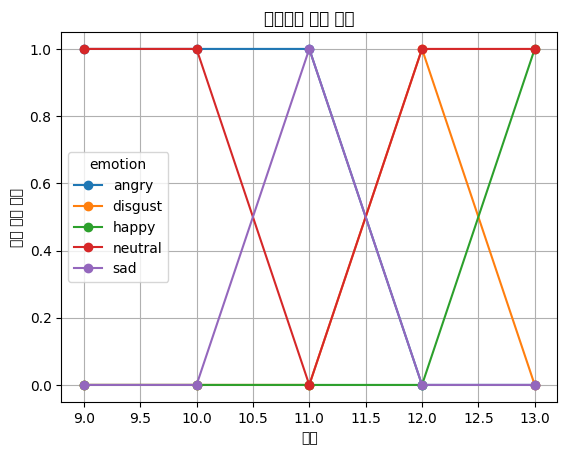

In [19]:
import matplotlib.pyplot as plt

# 시간 단위로 감정 수 count
df["hour"] = df["timestamp"].dt.hour
hourly_counts = df.groupby(["hour", "emotion"]).size().unstack(fill_value=0)

# 시각화
hourly_counts.plot(kind="line", marker="o")
plt.title("시간대별 감정 변화")
plt.xlabel("시간")
plt.ylabel("감정 발생 건수")
plt.grid(True)
plt.show()

In [25]:
import pandas as pd

# 예시 데이터: 시간별 감정
data = {
    "time": ["08:00", "09:00", "10:00", "11:00", "12:00"],
    "angry":   [0, 1, 0, 0, 0],
    "happy":   [0, 0, 1, 0, 0],
    "neutral": [1, 0, 0, 1, 1],
    "sad":     [0, 0, 0, 1, 0],
    "disgust": [0, 0, 0, 0, 1],
}
df = pd.DataFrame(data)

C:\Users\asia\AppData\Local\Temp\ipykernel_18412\1403261311.py:15: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\asia\AppData\Local\Temp\ipykernel_18412\1403261311.py:15: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\asia\AppData\Local\Temp\ipykernel_18412\1403261311.py:15: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\asia\AppData\Local\Temp\ipykernel_18412\1403261311.py:15: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\asia\AppData\Local\Temp\ipykernel_18412\1403261311.py:15: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\asia\AppData\Local\Temp\ipykernel_18412\1403261311.py:15: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from f

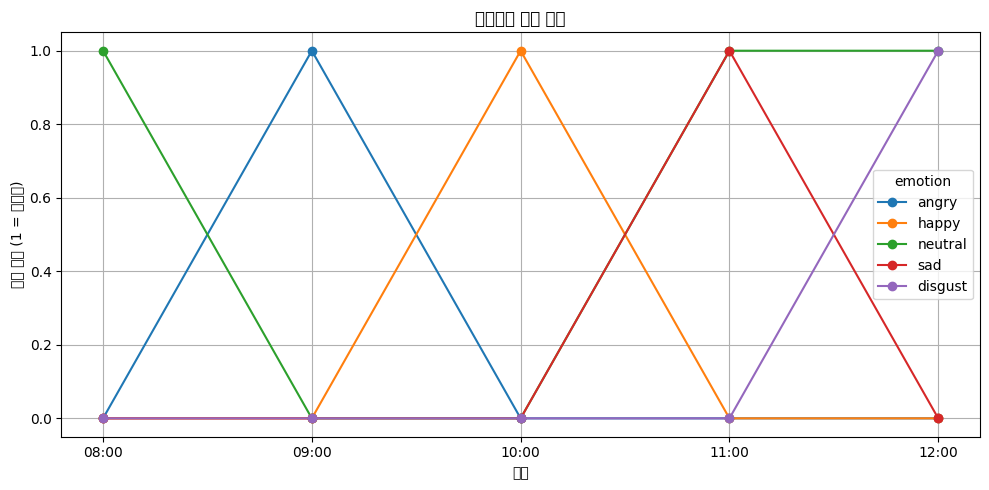

In [26]:
import matplotlib.pyplot as plt

emotion_cols = ["angry", "happy", "neutral", "sad", "disgust"]

plt.figure(figsize=(10, 5))

for emo in emotion_cols:
    plt.plot(df["time"], df[emo], marker='o', label=emo)

plt.title("시간대별 감정 변화")
plt.xlabel("시간")
plt.ylabel("감정 발생 (1 = 탐지됨)")
plt.legend(title="emotion")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\asia\.conda\envs\py312tf9\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asia\.conda\envs\py312tf9\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asia\.conda\envs\py312tf9\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asia\.conda\envs\py312tf9\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\asia\.conda\envs\py312tf9\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from fon

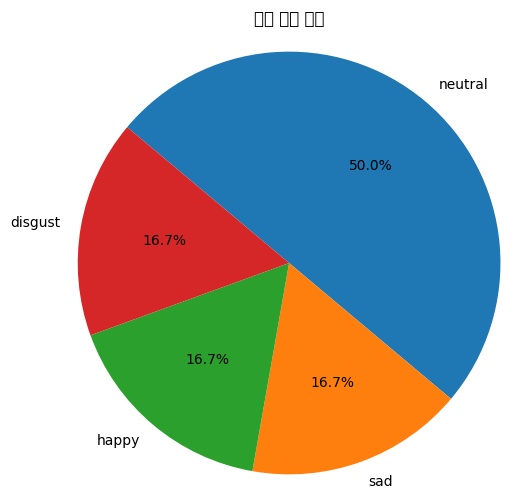

In [22]:
# 감정별 개수 세기
emotion_counts = Counter(emotions)

# 라벨과 값 분리
labels = list(emotion_counts.keys())
sizes = list(emotion_counts.values())

# 파이 차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, counterclock=False)
plt.title("오늘 감정 비율")
plt.axis('equal')  # 원형으로 보이게
plt.show()

In [20]:
def generate_natural_summary(counts_today, counts_yesterday):
    summary = []
    for emotion in set(counts_today.keys()).union(counts_yesterday.keys()):
        diff = counts_today.get(emotion, 0) - counts_yesterday.get(emotion, 0)
        if diff > 0:
            summary.append(f"{emotion}이 {diff}건 늘었어요.")
        elif diff < 0:
            summary.append(f"{emotion}이 {abs(diff)}건 줄었어요.")
    return " ".join(summary)

In [21]:
docs = []
for date, group in df.groupby("date"):
    contents = "\n".join(group["text"].tolist())
    docs.append(Document(page_content=f"{date}의 사용자 발화:\n{contents}"))


KeyError: 'text'